# Chessformer - Preliminary data analysis

## Imports

In [1]:
# @title Imports {display-mode: "form"}
%matplotlib inline
import dask
import dask.dataframe as dd
import logging
import matplotlib.pyplot as plt
import pyarrow as pa

from dask.distributed import Client

_ = dask.config.set(scheduler="threads")

In [2]:
client = Client(n_workers=4, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52425,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52436,Total threads: 2
Dashboard: http://127.0.0.1:52441/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52428,


## Data analysis

In [3]:
data = dd.read_parquet(
    path="data/headers/*.parquet.zstd",
    compression="zstd"
)
data = data[(data["WhiteElo"] > 0) & (data["BlackElo"] > 0)]
print(data.dtypes)
data.head(10)

Event          category
Result         category
WhiteElo         uint16
BlackElo         uint16
TimeControl    category
Termination    category
dtype: object


,Event,Result,WhiteElo,BlackElo,TimeControl,Termination
0,Rated Classical game,1-0,1639,1403,600+8,Normal
1,Rated Classical game,1-0,1654,1919,480+2,Normal
2,Rated Classical game,1-0,1643,1747,420+17,Normal
3,Rated Bullet game,0-1,1824,1973,60+1,Normal
4,Rated Bullet game,0-1,1765,1815,60+1,Normal
5,Rated Blitz game,1-0,1477,1487,300+3,Time forfeit
6,Rated Blitz game,0-1,1541,1500,300+0,Normal
7,Rated Classical game,1-0,1765,1752,540+0,Normal
8,Rated Classical game,1-0,1445,1169,900+0,Normal
9,Rated Blitz game,0-1,1522,1428,180+5,Normal


In [4]:
event_types_frequencies = data["Event"].value_counts().compute()
event_types_frequencies.head(7)

Event
Rated Blitz game             2046867409
Rated Bullet game            1510619343
Rated Rapid game              578621014
Rated Classical game          114307846
Rated UltraBullet game         29005219
Rated Standard game            17081459
Rated Correspondence game      11358303
Name: count, dtype: int64

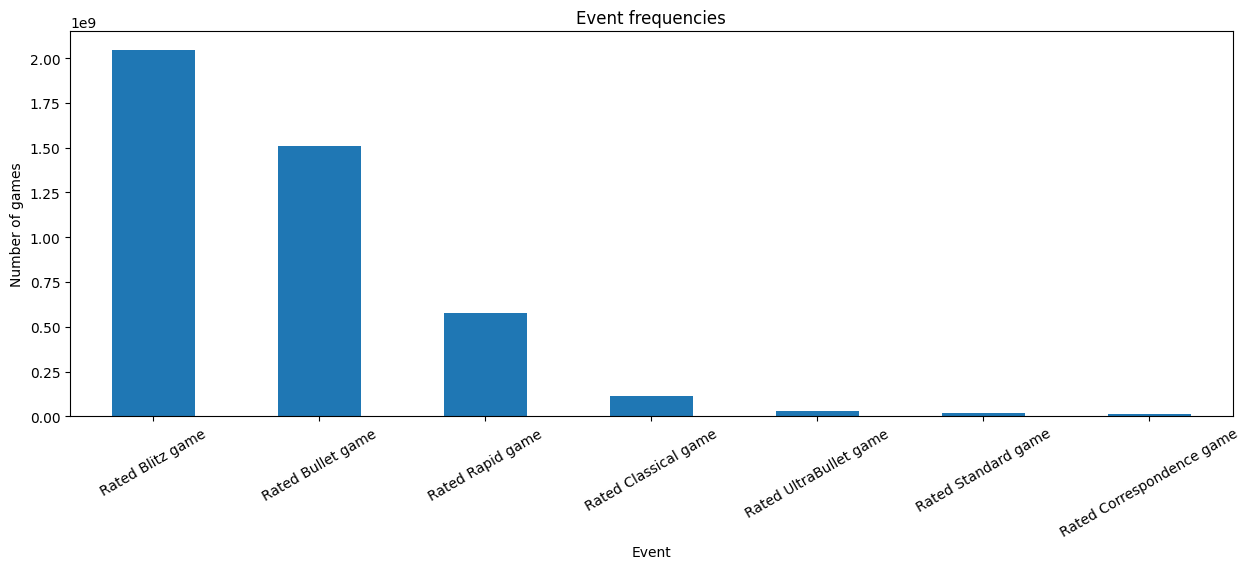

In [8]:
axis = event_types_frequencies.head(7).plot.bar("bar", figsize=(15, 5))
plt.title("Event frequencies")
plt.xlabel("Event")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

In [4]:
blitz_games = data[data["Event"] == "Rated Blitz game"].drop(columns=["Event"])
blitz_games.head()

,Result,WhiteElo,BlackElo,TimeControl,Termination
5,1-0,1477,1487,300+3,Time forfeit
6,0-1,1541,1500,300+0,Normal
9,0-1,1522,1428,180+5,Normal
13,1-0,1436,1506,420+0,Normal
14,1/2-1/2,1878,1940,300+0,Normal


In [5]:
schema = pa.schema({
    "Result": pa.dictionary(pa.int16(), pa.string()),
    "WhiteElo": pa.uint16(),
    "BlackElo": pa.uint16(),
    "TimeControl": pa.dictionary(pa.int16(), pa.string()),
    "Termination": pa.dictionary(pa.int16(), pa.string())
})
blitz_games.to_parquet(
    "data/tmp/blitz_games_headers.parquet.zstd",
    engine="pyarrow",
    compression="zstd",
    schema=schema
)

In [4]:
blitz_games = dd.read_parquet("data/tmp/blitz_games_headers.parquet.zstd", compression="zstd")

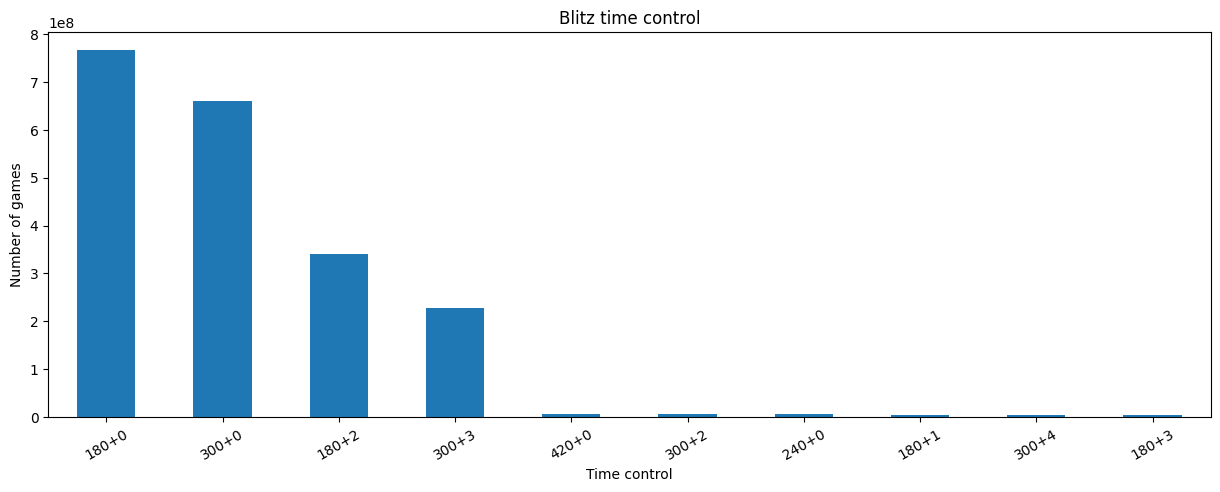

In [9]:
time_control_frequencies = blitz_games["TimeControl"].value_counts().compute()
axis = time_control_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz time control")
plt.xlabel("Time control")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

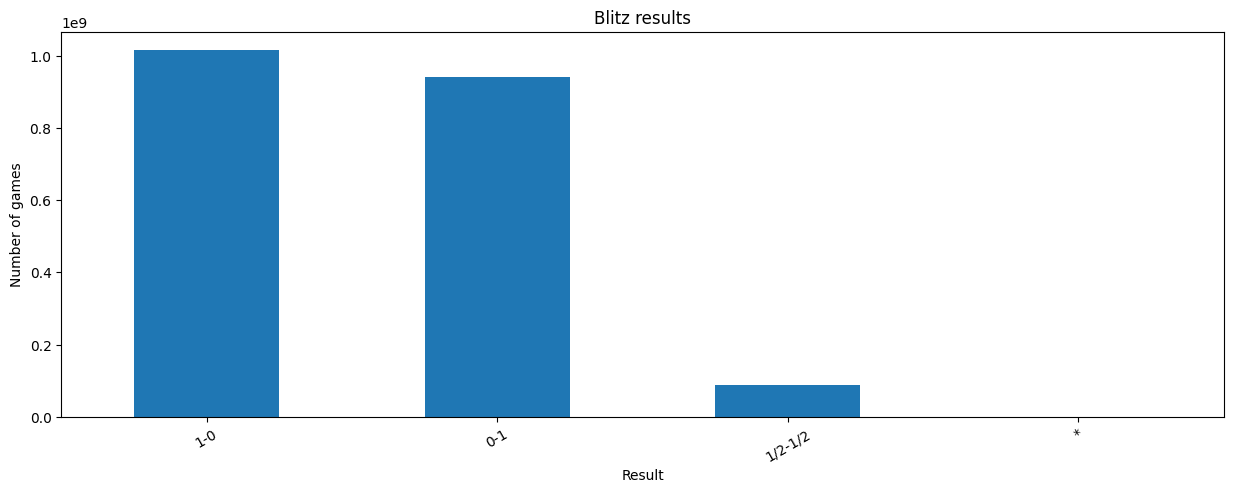

In [19]:
result_frequencies = blitz_games["Result"].value_counts().compute()
axis = result_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz results")
plt.xlabel("Result")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

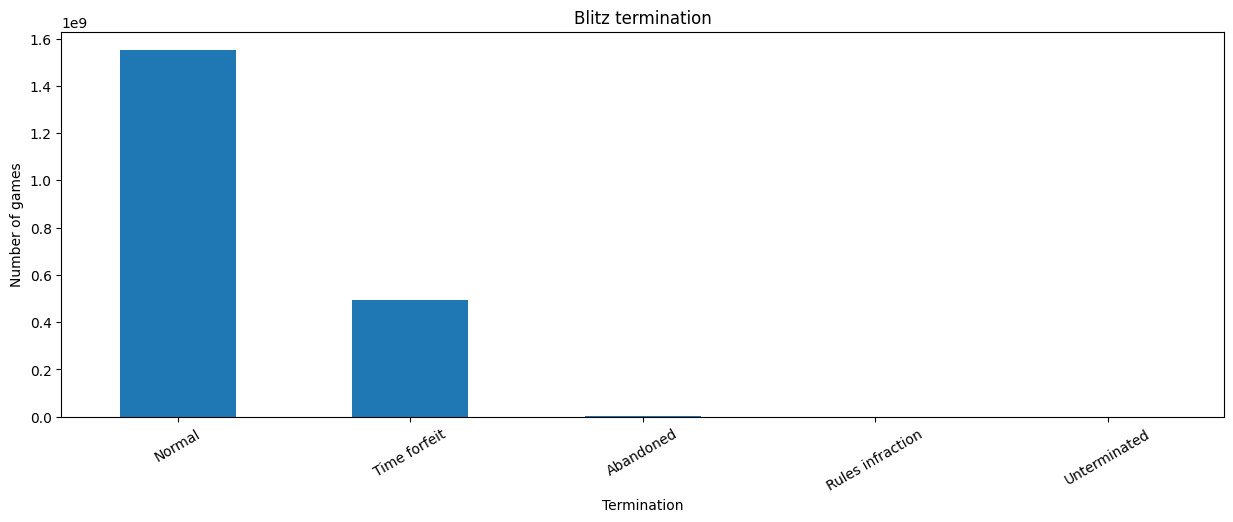

In [20]:
termination_frequencies = blitz_games["Termination"].value_counts().compute()
axis = termination_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz termination")
plt.xlabel("Termination")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

In [17]:
blitz_games.describe(include=["uint16"]).compute()

,WhiteElo,BlackElo
count,2046867409,2046867409
mean,1619.444639,1619.382711
std,360.688706,360.808637
min,400,400
25%,1509.0,1506.0
50%,1719.0,1717.0
75%,1949.0,1949.0
max,3969,3996
